In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path


# Set style for plots - clean, no grid
sns.set_style("white")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

custom_colors = ['#FFC1AD', '#FF6B35', '#CC4B24']  # Orange, Blue, Teal - high contrast

# C1, metric = accuracy

In [2]:
c1_results = []

c1_run_files = [
    ('claude-opus-4-5', 'runs/claude-opus-4-5-20251101_parallel/q2_isomer_set_yes_no_q2_balanced.jsonl'),
    ('gpt-5.2', 'runs/gpt-5.2_parallel/q2_isomer_set_yes_no_q2_balanced.jsonl'),
    ('gemini-3-pro-preview', 'runs/gemini-3-pro-preview_parallel/q2_isomer_set_yes_no_q2_balanced.jsonl'),
]
for model, file_path in c1_run_files:
    with open(file_path, 'r') as f:
        for line in f:
            res = json.loads(line)
            c1_results.append([model, res['n_molecules'], res['score']['correct']])

c1_results = pd.DataFrame(c1_results, columns=['Model', 'n_molecules', 'correct'])
c1_results['n_mol bin'] = pd.cut(c1_results['n_molecules'], bins=[0, 19, 39, 60], labels=['<20', '20-40', '>=40'])
c1_results_agg = c1_results.groupby(['Model', 'n_mol bin'], observed=True).agg({'correct': 'mean'}).reset_index()
c1_results_agg['Task'] = 'C1'
c1_results_agg.rename(columns={'correct': 'Task Completion'}, inplace=True)
c1_results_agg

,Model,n_mol bin,Task Completion,Task
0,claude-opus-4-5,<20,0.600000,C1
1,claude-opus-4-5,20-40,0.757500,C1
2,claude-opus-4-5,>=40,0.763333,C1
3,gemini-3-pro-preview,<20,0.643333,C1
4,gemini-3-pro-preview,20-40,0.755000,C1
5,gemini-3-pro-preview,>=40,0.873333,C1
6,gpt-5.2,<20,0.503333,C1
7,gpt-5.2,20-40,0.500000,C1
8,gpt-5.2,>=40,0.500000,C1


# C3, metric = recall

In [3]:
# Define the runs to analyze
c3_run_files = [
    ('claude-opus-4-5', 'runs/claude-opus-4-5-20251101_parallel/q3_missing_isomers.jsonl'),
    ('gpt-5.2', 'runs/gpt-5.2_parallel/q3_missing_isomers.jsonl'),
    ('gemini-3-pro-preview', 'runs/gemini-3-pro-preview_parallel/q3_missing_isomers_v2.jsonl'),
]

# Load all runs
c3_results = []

for model_name, file_path in c3_run_files:
    if not Path(file_path).exists():
        print(f"Warning: {file_path} not found, skipping...")
        continue
    
    with open(file_path, 'r') as f:
        for line in f:
            result = json.loads(line)
            result['model_name'] = model_name
            c3_results.append([model_name, result['n_molecules'], result['score']['recall']])

c3_results = pd.DataFrame(c3_results, columns=['Model', 'n_molecules', 'recall'])
c3_results['n_mol bin'] = pd.cut(c3_results['n_molecules'], bins=[0, 19, 39, 60], labels=['<20', '20-40', '>=40'])
c3_results_agg = c3_results.groupby(['Model', 'n_mol bin'], observed=True).agg({'recall': 'mean'}).reset_index()
c3_results_agg['Task'] = 'C3'
c3_results_agg.rename(columns={'recall': 'Task Completion'}, inplace=True)

In [4]:
c3_results_agg

,Model,n_mol bin,Task Completion,Task
0,claude-opus-4-5,<20,0.341350,C3
1,claude-opus-4-5,20-40,0.313380,C3
2,claude-opus-4-5,>=40,0.252647,C3
3,gemini-3-pro-preview,<20,0.416656,C3
4,gemini-3-pro-preview,20-40,0.362119,C3
5,gemini-3-pro-preview,>=40,0.258756,C3
6,gpt-5.2,<20,0.141507,C3
7,gpt-5.2,20-40,0.139621,C3
8,gpt-5.2,>=40,0.102322,C3


# C2, metric = overlap metric

In [5]:
from rdkit import Chem

def calculate_dbe(smiles):
    """Calculate Double Bond Equivalents (Degree of Unsaturation)"""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    
    c_count = sum(1 for atom in mol.GetAtoms() if atom.GetSymbol() == 'C')
    n_count = sum(1 for atom in mol.GetAtoms() if atom.GetSymbol() == 'N')
    h_count = sum(atom.GetTotalNumHs() for atom in mol.GetAtoms())
    x_count = sum(1 for atom in mol.GetAtoms() if atom.GetSymbol() in ['F', 'Cl', 'Br', 'I'])
    
    dbe = (2 * c_count + 2 + n_count - h_count - x_count) / 2
    return dbe

def get_num_atoms(smiles):
    """Get number of heavy atoms in molecule"""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    return mol.GetNumHeavyAtoms()

def is_substructure(query_smiles, target_smiles):
    """Check if query is a substructure of target"""
    query_mol = Chem.MolFromSmiles(query_smiles)
    target_mol = Chem.MolFromSmiles(target_smiles)
    
    if query_mol is None or target_mol is None:
        return False
    
    return target_mol.HasSubstructMatch(query_mol)

def calculate_overlap_metric(response_smiles, correct_smiles):
    """Calculate atom overlap metric: N_overlap / max(N_response, N_correct)"""
    response_mol = Chem.MolFromSmiles(response_smiles)
    correct_mol = Chem.MolFromSmiles(correct_smiles)
    
    if response_mol is None or correct_mol is None:
        return 0.0
    
    n_response = response_mol.GetNumHeavyAtoms()
    n_correct = correct_mol.GetNumHeavyAtoms()
    
    if correct_mol.HasSubstructMatch(response_mol):
        n_overlap = n_response
    elif response_mol.HasSubstructMatch(correct_mol):
        n_overlap = n_correct
    else:
        from rdkit.Chem import rdFMCS
        mcs = rdFMCS.FindMCS([response_mol, correct_mol], timeout=5)
        if mcs.smartsString:
            mcs_mol = Chem.MolFromSmarts(mcs.smartsString)
            if mcs_mol:
                n_overlap = mcs_mol.GetNumHeavyAtoms()
            else:
                n_overlap = 0
        else:
            n_overlap = 0
    
    max_atoms = max(n_response, n_correct)
    if max_atoms == 0:
        return 0.0
    
    return n_overlap / max_atoms


# Load the dataset to get ground truth and metadata
dataset = []
with open('data/dataset_q1a_fixed_smiles.jsonl', 'r') as f:
    for line in f:
        dataset.append(json.loads(line))

# Filter for Q1a tasks only
q1a_dataset = [d for d in dataset if d['task'] == 'q1a_largest_common_motif_chembl']

# Create a lookup by instance ID
dataset_lookup = {d['id']: d for d in q1a_dataset}

print(f"Total Q1a instances in dataset: {len(q1a_dataset)}")

c2_run_files = [
    ('claude-opus-4-5', 'runs/claude-opus-4-5-20251101_parallel/q1a_largest_common_motif_chembl_q1a_fixed_smiles.jsonl'),
    ('gpt-5.2', 'runs/gpt-5.2_parallel/q1a_largest_common_motif_chembl_q1a_fixed_smiles.jsonl'),
    ('gemini-3-pro-preview', 'runs/gemini-3-pro-preview_parallel/q1a_largest_common_motif_chembl_q1a_fixed_smiles.jsonl'),
]

# Load all runs
all_results = []

for model_name, file_path in c2_run_files:
    if not Path(file_path).exists():
        print(f"Warning: {file_path} not found, skipping...")
        continue
    
    with open(file_path, 'r') as f:
        for line in f:
            result = json.loads(line)
            result['model_name'] = model_name
            all_results.append(result)

# Enrich results with additional metrics
enriched_results = []

for result in all_results:
    instance_id = result['id']
    
    if instance_id not in dataset_lookup:
        print(f"Warning: {instance_id} not found in dataset")
        continue
    
    dataset_info = dataset_lookup[instance_id]
    
    correct_smiles = result['score'].get('gold_canonical') or result['score'].get('gold')
    response_smiles = result['score'].get('pred_canonical') or result['score'].get('pred')
    
    if response_smiles is None:
        enriched = {
            'id': instance_id,
            'model': result['model_name'],
            'n_molecules': result['n_molecules'],
            'correct': result['score']['correct'],
            'response_smiles': None,
            'correct_smiles': correct_smiles,
            'response_is_substructure_of_correct': False,
            'correct_is_substructure_of_response': False,
            'overlap_metric': 0.0,
            'n_atoms_response': 0,
            'n_atoms_correct': get_num_atoms(correct_smiles) if correct_smiles else None,
            'dbe_response': None,
            'dbe_correct': calculate_dbe(correct_smiles) if correct_smiles else None,
            'avg_n_atoms_molecules': np.mean([get_num_atoms(m) for m in dataset_info['molecules'] if get_num_atoms(m) is not None]),
            'avg_dbe_molecules': np.mean([calculate_dbe(m) for m in dataset_info['molecules'] if calculate_dbe(m) is not None]),
        }
        enriched_results.append(enriched)
        continue
    
    response_is_sub = is_substructure(response_smiles, correct_smiles) if correct_smiles else False
    correct_is_sub = is_substructure(correct_smiles, response_smiles) if correct_smiles else False
    overlap = calculate_overlap_metric(response_smiles, correct_smiles) if correct_smiles else 0.0
    
    n_atoms_response = get_num_atoms(response_smiles)
    n_atoms_correct = get_num_atoms(correct_smiles) if correct_smiles else None
    
    dbe_response = calculate_dbe(response_smiles)
    dbe_correct = calculate_dbe(correct_smiles) if correct_smiles else None
    
    molecule_atoms = [get_num_atoms(m) for m in dataset_info['molecules']]
    molecule_atoms = [a for a in molecule_atoms if a is not None]
    avg_n_atoms_molecules = np.mean(molecule_atoms) if molecule_atoms else None
    
    molecule_dbes = [calculate_dbe(m) for m in dataset_info['molecules']]
    molecule_dbes = [d for d in molecule_dbes if d is not None]
    avg_dbe_molecules = np.mean(molecule_dbes) if molecule_dbes else None
    
    enriched = {
        'id': instance_id,
        'model': result['model_name'],
        'n_molecules': result['n_molecules'],
        'correct': result['score']['correct'],
        'response_smiles': response_smiles,
        'correct_smiles': correct_smiles,
        'response_is_substructure_of_correct': response_is_sub,
        'correct_is_substructure_of_response': correct_is_sub,
        'overlap_metric': overlap,
        'n_atoms_response': n_atoms_response,
        'n_atoms_correct': n_atoms_correct,
        'dbe_response': dbe_response,
        'dbe_correct': dbe_correct,
        'avg_n_atoms_molecules': avg_n_atoms_molecules,
        'avg_dbe_molecules': avg_dbe_molecules,
    }
    
    enriched_results.append(enriched)

# Convert to DataFrame
df = pd.DataFrame(enriched_results)

print(f"\nEnriched results: {len(df)} instances")
print(f"\nSample of enriched data:")
print(df.head())

Total Q1a instances in dataset: 1016


[11:16:15] Can't kekulize mol.  Unkekulized atoms: 5 6 7
[11:16:15] Can't kekulize mol.  Unkekulized atoms: 5 6 7
[11:16:15] Can't kekulize mol.  Unkekulized atoms: 5 6 7
[11:16:15] Can't kekulize mol.  Unkekulized atoms: 5 6 7
[11:16:15] Can't kekulize mol.  Unkekulized atoms: 5 6 7
[11:16:18] SMILES Parse Error: unclosed ring for input: 'CC(CN(C)C)CN1c2ccccc2'
[11:16:18] SMILES Parse Error: unclosed ring for input: 'CC(CN(C)C)CN1c2ccccc2'
[11:16:18] SMILES Parse Error: unclosed ring for input: 'CC(CN(C)C)CN1c2ccccc2'
[11:16:18] SMILES Parse Error: unclosed ring for input: 'CC(CN(C)C)CN1c2ccccc2'
[11:16:18] SMILES Parse Error: unclosed ring for input: 'CC(CN(C)C)CN1c2ccccc2'
[11:16:32] SMILES Parse Error: unclosed ring for input: 'CC1(C2CCC3=CC(=O)C=CC3(C)C2C(O)CC2(C)C1CC1C)C'
[11:16:32] SMILES Parse Error: unclosed ring for input: 'CC1(C2CCC3=CC(=O)C=CC3(C)C2C(O)CC2(C)C1CC1C)C'
[11:16:32] SMILES Parse Error: unclosed ring for input: 'CC1(C2CCC3=CC(=O)C=CC3(C)C2C(O)CC2(C)C1CC1C)C'
[11


Enriched results: 3048 instances

Sample of enriched data:
             id            model  n_molecules  correct  \
0  q1a_n5_00001  claude-opus-4-5            5     True   
1  q1a_n5_00002  claude-opus-4-5            5    False   
2  q1a_n5_00003  claude-opus-4-5            5    False   
3  q1a_n5_00004  claude-opus-4-5            5    False   
4  q1a_n5_00005  claude-opus-4-5            5    False   

                         response_smiles                   correct_smiles  \
0                         O=CC1CCC(=O)N1                   O=CC1CCC(=O)N1   
1                      O=c1[nH]c(=O)ncc1   O=c1ccn(C2CCC(CO)O2)c(=O)[nH]1   
2           c1ccc(N2CCN(c3ccccc3)CC2)cc1                  CCN(CC)c1ccccc1   
3                               C1COCCN1                       CCN1CCOCC1   
4  NCC1CC(O)C(O)C(OC2C(N)CC(N)C(O)C2O)O1  NCC1CCCC(OC2C(N)CC(N)C(O)C2O)O1   

   response_is_substructure_of_correct  correct_is_substructure_of_response  \
0                                 True           

In [6]:
df['n_mol bin'] = pd.cut(df['n_molecules'], bins=[0, 19, 39, 60], labels=['<20', '20-40', '>=40'])

c2_results = df.groupby([
    'model',
    'n_mol bin',
    'n_molecules',
], observed=True).agg({
    'correct': 'mean',
    'response_is_substructure_of_correct': 'mean',
    'correct_is_substructure_of_response': 'mean',
    'overlap_metric': 'mean'}).reset_index()

In [7]:
c2_results_agg = c2_results.groupby(['model', 'n_mol bin'], observed=True).agg({'correct': 'mean', 'response_is_substructure_of_correct': 'mean', 'correct_is_substructure_of_response': 'mean', 'overlap_metric': 'mean'})

In [8]:
c2_results_agg['is_substructure'] = 0.5*(c2_results_agg['correct_is_substructure_of_response'] + c2_results_agg['response_is_substructure_of_correct'])
c2_results_agg

correct  response_is_substructure_of_correct  \
model                n_mol bin                                                  
claude-opus-4-5      <20        0.177778                             0.436111   
                     20-40      0.177083                             0.379167   
                     >=40       0.181687                             0.434668   
gemini-3-pro-preview <20        0.191667                             0.433333   
                     20-40      0.097917                             0.395833   
                     >=40       0.066758                             0.402940   
gpt-5.2              <20        0.127778                             0.472222   
                     20-40      0.070833                             0.314583   
                     >=40       0.081522                             0.356730   

                                correct_is_substructure_of_response  \
model                n_mol bin                                        
claude-opus-4-5      <20                                   0.338889   
                     20-40                                 0.454167   
                     >=40                                  0.360165   
gemini-3-pro-preview <20                                   0.430556   
                     20-40                                 0.427083   
                     >=40                                  0.180885   
gpt-5.2              <20                                   0.275000   
                     20-40                                 0.354167   
                     >=40                                  0.388534   

                                overlap_metric  is_substructure  
model                n_mol bin                                   
claude-opus-4-5      <20              0.782916         0.387500  
                     20-40            0.780977         0.416667  
                     >=40             0.798648         0.397417  
gemini-3-pro-preview <20              0.761280         0.431944  
                     20-40            0.716727         0.411458  
                     >=40             0.458724         0.291912  
gpt-5.2              <20              0.662724         0.373611  
                     20-40            0.688392         0.334375  
                     >=40             0.688987         0.372632

In [9]:
c2_results_agg = c2_results_agg['is_substructure'].reset_index()
c2_results_agg['Task'] = 'C2'
c2_results_agg.rename(columns={'is_substructure': 'Task Completion', 'model': 'Model'}, inplace=True)
c2_results_agg

,Model,n_mol bin,Task Completion,Task
0,claude-opus-4-5,<20,0.387500,C2
1,claude-opus-4-5,20-40,0.416667,C2
2,claude-opus-4-5,>=40,0.397417,C2
3,gemini-3-pro-preview,<20,0.431944,C2
4,gemini-3-pro-preview,20-40,0.411458,C2
5,gemini-3-pro-preview,>=40,0.291912,C2
6,gpt-5.2,<20,0.373611,C2
7,gpt-5.2,20-40,0.334375,C2
8,gpt-5.2,>=40,0.372632,C2


# Aggregate results

/tmp/ipykernel_569106/1977925044.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels([
/tmp/ipykernel_569106/1977925044.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels([
/tmp/ipykernel_569106/1977925044.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels([
/tmp/ipykernel_569106/1977925044.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels([
/tmp/ipykernel_569106/1977925044.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels([
/tmp/ipykernel_56910

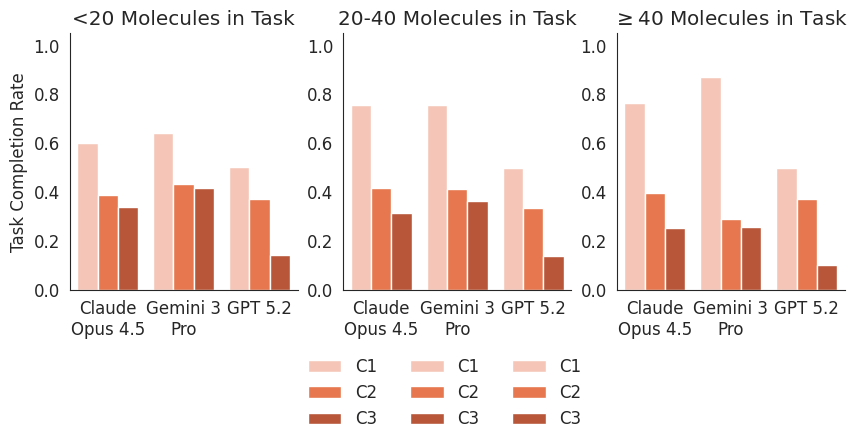

In [33]:
fig, axes = plt.subplots(1, 3, figsize=(10, 10/3))
plt.rcParams['font.size'] = 12

all_task_results = pd.concat([c1_results_agg, c2_results_agg, c3_results_agg])
all_task_results.sort_values(by=['Task', 'Model'], inplace=True)

for i, n_mol_bin in enumerate(['<20', '20-40', '>=40']):
    all_task_results_n_mol_bin = all_task_results[all_task_results['n_mol bin'] == n_mol_bin]
    ax = sns.barplot(x='Model', y='Task Completion', data=all_task_results_n_mol_bin, hue='Task', palette=custom_colors, ax=axes[i])
    axes[i].legend_.remove()
    sns.despine()
    axes[i].set_xticklabels([
        "Claude Opus 4.5",
        "Gemini 3 Pro",
        "GPT 5.2"
    ])
    axes[i].set_ylim([0, 1.05])
    if i == 0:
        axes[i].set_ylabel("Task Completion Rate")
    else:
        axes[i].set_ylabel('')
    axes[i].set_xlabel('')
    if n_mol_bin == '>=40':
        n_mol_bin = '$\geq 40$'
    axes[i].set_title(f'{n_mol_bin} Molecules in Task')
    axes[i].set_xticklabels([
        "Claude\nOpus 4.5",
        "Gemini 3\nPro",
        "GPT 5.2"
    ])

fig.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.35), frameon=False)
plt.savefig('plots/chemistry_task_completion_rates_by_n_mol.png', dpi=300, bbox_inches='tight')
plt.show()

In [11]:

# ax = sns.barplot(x='Model', y='Task Completion', data=all_task_results, hue='Task', palette=custom_colors)
# ax.legend_.remove()
# fig.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.07), frameon=False)
# sns.despine()

# plt.ylim([0, 1.05])
# plt.ylabel("Task Completion Rate")
# plt.xlabel('')
# ax.set_xticklabels([
#     "Claude Opus 4.5",
#     "Gemini 3 Pro",
#     "GPT 5.2"
# ])
# plt.tight_layout()
# plt.savefig('plots/chemistry_task_completion_rates.png', dpi=300, bbox_inches='tight')
# plt.show()

# Statistics for paper

In [12]:
c1_results.groupby(['n_molecules'])[['correct']].mean()

,correct
n_molecules,
5,0.560000
10,0.583333
15,0.603333
20,0.623333
25,0.656667
30,0.673333
35,0.730000
40,0.703333
45,0.723333


In [13]:
c1_results.groupby(['n_molecules'])[['correct']].mean().mean()

correct    0.656667
dtype: float64

In [14]:
c2_results['is_substructure'] = 0.5*(c2_results['correct_is_substructure_of_response'] + c2_results['response_is_substructure_of_correct'])
c2_results.groupby(['n_molecules'])[['is_substructure']].mean().mean()

is_substructure    0.380502
dtype: float64

In [15]:
c2_results.groupby(['n_molecules'])[['is_substructure']].mean()

,is_substructure
n_molecules,
5,0.430556
10,0.369444
15,0.393056
20,0.427778
25,0.366667
30,0.356944
35,0.398611
40,0.401316
45,0.380503


In [16]:
c2_results_per_mol = c2_results.groupby(['n_molecules'])[['is_substructure']].mean().reset_index()
print(c2_results_per_mol[c2_results_per_mol['n_molecules'] < 50].mean())
print(c2_results_per_mol[c2_results_per_mol['n_molecules'] < 50].std())

n_molecules        25.000000
is_substructure     0.391653
dtype: float64
n_molecules        13.693064
is_substructure     0.026002
dtype: float64


In [17]:
c3_results.groupby(['n_molecules'])[['recall']].mean().mean()

recall    0.260006
dtype: float64

In [18]:
c3_results.groupby(['n_molecules'])[['recall']].mean()

,recall
n_molecules,
5,0.299049
10,0.287787
15,0.312678
20,0.288921
25,0.285573
30,0.265460
35,0.246873
40,0.209530
45,0.192041
